In [5]:
import wandb 
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor

from glob import glob as glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import random
import cv2

from torchsummary import summary
from skimage import transform
from skimage.transform import resize
import torchio as tio



In [6]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/laxmi/.netrc


True

In [8]:
wandb.init(
    project="MedHack",
    config={
        "epochs":10,
        "batch_size":3,
        "lr":0.01
        }
    )

wandb: Currently logged in as: justkantapoudel (gces). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.log("test_loss":test_loss.item())
wandb.Image

In [69]:
my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_device

device(type='cpu')

# Dataset

In [70]:
def load_nifty(directory, example_id, suffix):
    file_path = os.path.join(directory, example_id + "_" + suffix + ".nii.gz")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No such file or no access: '{file_path}'")
    return nib.load(file_path)

In [71]:
def load_channels(directory, example_id):
    flair = load_nifty(directory, example_id, "flair")
    t1 = load_nifty(directory, example_id, "t1")
    t1ce = load_nifty(directory, example_id, "t1ce")
    t2 = load_nifty(directory, example_id, "t2")
    return flair, t1, t1ce, t2


In [72]:
def prepare_nifty(d, output_dir):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header

    # Load data for each modality
    flair_data = get_data(flair)
    t1_data = get_data(t1)
    t1ce_data = get_data(t1ce)
    t2_data = get_data(t2)

    # Combine into a single volume
    combined_volume = np.stack([flair_data, t1_data, t1ce_data, t2_data], axis=3)

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the combined volume in the output directory
    img_path = os.path.join(output_dir, example_id + ".nii.gz")
    vol = nib.Nifti1Image(combined_volume, affine, header=header)
    nib.save(vol, img_path)

    # Process segmentation if available
    mask_path = ""
    seg_path = os.path.join(d, example_id + "_seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path)
        affine, header = seg.affine, seg.header
        seg_data = get_data(seg, "uint8")
        seg_data[seg_data == 4] = 3  # Adjust labels if necessary
        seg = nib.Nifti1Image(seg_data, affine, header=header)
        mask_path = os.path.join(output_dir, example_id + "_seg.nii.gz")
        nib.save(seg, mask_path)

    return img_path, mask_path

In [73]:
def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0  # Handle edge cases
        return data
    return nifty.get_fdata().astype(np.uint8)

# Path to the main directory containing all the subjects
main_directory = "archive/BraTS2021_Training_Data/test"
output_directory = "archive/BraTS2021_Training_Data/processed_train"

# Initialize lists to store paths
train_volume_path = []
train_segmentation_path = []

In [74]:
for subject_dir in os.listdir(main_directory):
    subject_path = os.path.join(main_directory, subject_dir)
    if os.path.isdir(subject_path):  # Check if it's a directory
        print(f"Processing {subject_path}...")
        try:
            # List the contents of the directory
            files = os.listdir(subject_path)
            print(f"Files in {subject_path}: {files}")
            
            img_path, mask_path = prepare_nifty(subject_path, output_directory)
            train_volume_path.append(img_path)
            train_segmentation_path.append(mask_path if mask_path else None)
        except FileNotFoundError as e:
            print(e)  # Print the error if any file is missing
        except Exception as e:
            print(f"An error occurred while processing {subject_path}: {e}")

# Convert lists to arrays
train_volume_path = np.array(train_volume_path)
train_segmentation_path = np.array(train_segmentation_path)

# Print the arrays
print("Train Volume Paths:", train_volume_path)
print("Train Segmentation Paths:", train_segmentation_path)


Processing archive/BraTS2021_Training_Data/test/BraTS2021_01620...
Files in archive/BraTS2021_Training_Data/test/BraTS2021_01620: ['BraTS2021_01620_flair.nii.gz', 'BraTS2021_01620_t1.nii.gz', 'BraTS2021_01620_t2.nii.gz', 'BraTS2021_01620_seg.nii.gz', 'BraTS2021_01620_t1ce.nii.gz']
Processing archive/BraTS2021_Training_Data/test/processed_val...
Files in archive/BraTS2021_Training_Data/test/processed_val: ['BraTS2021_01578.nii.gz', 'BraTS2021_01578_seg.nii.gz']
No such file or no access: 'archive/BraTS2021_Training_Data/test/processed_val/processed_val_flair.nii.gz'
Processing archive/BraTS2021_Training_Data/test/BraTS2021_01628...
Files in archive/BraTS2021_Training_Data/test/BraTS2021_01628: ['BraTS2021_01628_flair.nii.gz', 'BraTS2021_01628_t1.nii.gz', 'BraTS2021_01628_seg.nii.gz', 'BraTS2021_01628_t1ce.nii.gz', 'BraTS2021_01628_t2.nii.gz']
Processing archive/BraTS2021_Training_Data/test/BraTS2021_01559...
Files in archive/BraTS2021_Training_Data/test/BraTS2021_01559: ['BraTS2021_0155

In [75]:
def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0  # Handle edge cases
        return data
    return nifty.get_fdata().astype(np.uint8)

# Path to the main directory containing all the subjects
main_directory_val = "archive/BraTS2021_Training_Data/val"
output_directory_val = "archive/BraTS2021_Training_Data/processed_val"

# Initialize lists to store paths
val_volumes_path = []
val_segmentations_path = []

In [76]:
for subject_dir in os.listdir(main_directory_val):
    subject_path = os.path.join(main_directory_val, subject_dir)
    if os.path.isdir(subject_path):  # Check if it's a directory
        print(f"Processing {subject_path}...")
        try:
            # List the contents of the directory
            files = os.listdir(subject_path)
            print(f"Files in {subject_path}: {files}")
            
            img_path, mask_path = prepare_nifty(subject_path, output_directory)
            val_volumes_path.append(img_path)
            val_segmentations_path.append(mask_path if mask_path else None)
        except FileNotFoundError as e:
            print(e)  # Print the error if any file is missing
        except Exception as e:
            print(f"An error occurred while processing {subject_path}: {e}")

# Convert lists to arrays
val_volumes_path = np.array(val_volumes_path)
val_segmentations_path = np.array(val_segmentations_path)

# Print the arrays
print("val Volume Paths:", val_volumes_path)
print("val Segmentation Paths:", val_segmentations_path)


Processing archive/BraTS2021_Training_Data/val/BraTS2021_01578...
Files in archive/BraTS2021_Training_Data/val/BraTS2021_01578: ['BraTS2021_01578_flair.nii.gz', 'BraTS2021_01578_t2.nii.gz', 'BraTS2021_01578_seg.nii.gz', 'BraTS2021_01578_t1ce.nii.gz', 'BraTS2021_01578_t1.nii.gz']
val Volume Paths: ['archive/BraTS2021_Training_Data/processed_train/BraTS2021_01578.nii.gz']
val Segmentation Paths: ['archive/BraTS2021_Training_Data/processed_train/BraTS2021_01578_seg.nii.gz']


In [77]:
nib.load(train_volume_path[0]).get_fdata().shape

(240, 240, 155, 4)

In [78]:
nib.load(train_segmentation_path[0]).get_fdata().shape

(240, 240, 155)

In [79]:
nib.load(val_volumes_path[0]).get_fdata().shape

(240, 240, 155, 4)

In [80]:
nib.load(val_segmentations_path[0]).get_fdata().shape

(240, 240, 155)

In [81]:
class permute_and_add_axis_to_mask(object):
    def __call__(self, sample):
        # Previous: (240, 240, 155, 4) , need to change to (4, 155, 240, 240) i.e. (channel, depth, height, width)
        image, mask = sample['image'], sample['mask']

        image = image.transpose((3, 2, 0, 1))
        mask = mask.transpose((2, 0, 1))

        mask= mask[np.newaxis, ...]
        return {'image':image,
                'mask':mask}

In [82]:
class BratsDataset(Dataset):
    def __init__(self, images_path_list, masks_path_list, transform=None):
        """
        Args:
            images_path_list (list of strings): List of paths to input images.
            masks_path_list (list of strings): List of paths to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_path_list = images_path_list
        self.masks_path_list = masks_path_list
        self.transform = transform
        self.length = len(images_path_list)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load image
        image_path = self.images_path_list[idx]
        image = nib.load(image_path).get_fdata()
        image = np.float32(image) # shape of image [240, 240, 155, 4]

        # Load mask
        mask_path = self.masks_path_list[idx]
        mask = nib.load(mask_path).get_fdata()
        mask = np.float32(mask) # shape of mask [240, 240, 155]

        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)
        
        return sample


In [83]:
rescale_transform = tio.Resize(
    keys=['image', 'mask'],
    target_shape=(128, 240, 240)
)

In [84]:
data_transform = Compose([ # input image of shape [240, 240, 155, 4]
    permute_and_add_axis_to_mask(), # image: [4, 155, 240, 240], mask[1, 155, 240, 240] # new channel in the first dimension is added in mask inorder to make compatible with Resize() as Resize takes only 4D tensor
    rescale_transform,
])

In [85]:
train_ds = BratsDataset(
    train_volume_path,
    train_segmentation_path,
    transform=data_transform
)

val_ds = BratsDataset(
    val_volumes_path,
    val_segmentations_path,
    transform=data_transform
)

In [86]:
train_ds[0]['image'].shape # previously numpy array of (240, 240, 155, 4), Now changed to: (4, 155, 240, 240)

torch.Size([4, 128, 240, 240])

In [87]:
train_ds[0]['mask'].shape # Before: (240, 240, 155) After:(1, 128, 240, 240)

torch.Size([1, 128, 240, 240])

In [88]:
sample_patient = train_ds[1]
sample_patient['image'].shape

torch.Size([4, 128, 240, 240])

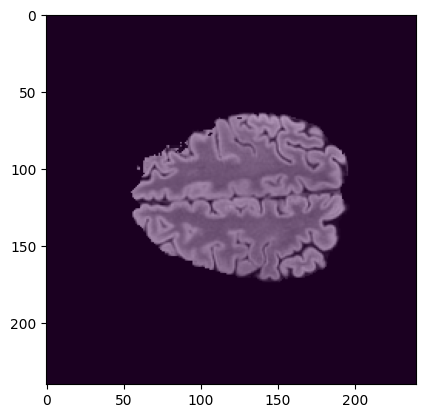

In [89]:
# This was made for previous dimension, now the dimension is changed, so need resurrection
# modality = 1
# slice_idx = 75
# plt.imshow(sample_patient['image'][:,:, slice_idx, modality], cmap='gray')
# plt.imshow(sample_patient['mask'][:,:, slice_idx], alpha=0.4)
# plt.show()

modality = 0
slice_idx = 90
plt.imshow(sample_patient['image'][modality, slice_idx, :, :], cmap='gray')
plt.imshow(sample_patient['mask'][0, slice_idx, :, :], alpha=0.4) # since channel dimension is also added on the mask volume
plt.show()

In [90]:
# patient_num = random.randint(0, len(train_ds)-1) # random patient
# slice_num = 75 # Extract 75th slice

# sample_image = train_ds[patient_num]['image'] # (240, 240, 155, 4)
# sample_mask = train_ds[patient_num]['mask'] # (240, 240, 155)

# sample_image_slice = sample_image[:,:, slice_num, :] # (240, 240, 4)
# sample_mask_slice = sample_mask[:,:, slice_num] # (240, 240)

# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
# labels = []

# # Iterate through first 4 modalities and display them
# for i, ax in enumerate(axes[:-1]):
#     ax.set_xlabel(f"")
#     ax.imshow(sample_image_slice[:,:,i], cmap='gray') # prints 4 modalities of image in 4 columns
#     ax.set_xticks([])
#     ax.set_yticks([])

# # Display the mask in last column
# axes[-1].imshow(sample_mask_slice)
# axes[-1].set_xticks([])
# axes[-1].set_yticks([])
# plt.show()


sample_mask_slice torch.Size([240, 240])


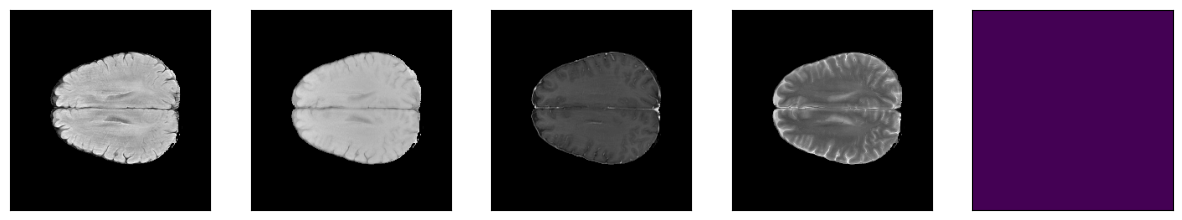

In [91]:
patient_num = random.randint(0, len(train_ds)-1) # random patient
slice_idx = 75 # Extract 75th slice

sample_image = train_ds[patient_num]['image'] # (4, 128, 240, 240)
sample_mask = train_ds[patient_num]['mask'] # (1, 128, 240, 240)
sample_image_slice = sample_image[:, slice_idx, :, :] # (4, 240, 240)
sample_mask_slice = sample_mask[0,slice_idx,:, :] # (240, 240)
print('sample_mask_slice', sample_mask_slice.shape)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
labels = []

# Iterate through first 4 modalities and display them
for i, ax in enumerate(axes[:-1]):
    ax.set_xlabel(f"")
    ax.imshow(sample_image_slice[i,:,:], cmap='gray') # prints 4 modalities of image in 4 columns
    ax.set_xticks([])
    ax.set_yticks([])

# Display the mask in last column
axes[-1].imshow(sample_mask_slice)
axes[-1].set_xticks([])
axes[-1].set_yticks([])
plt.show()


# DataLoader

In [92]:
# Create dataloader
train_loader = DataLoader(dataset=train_ds,
                          batch_size=2,
                          shuffle=True)
val_loader = DataLoader(dataset=val_ds,
                        batch_size=1,
                        shuffle=False)

Sanity Check: Iterate through dataloader and check the size

In [93]:
for batch in train_loader:
    images = batch['image']
    masks = batch['mask']
    print(f'Batch images shape {images.shape}')
    print(f'Batch masks shape {masks.shape}')
    print('--------------------')
    break

Batch images shape torch.Size([2, 4, 128, 240, 240])
Batch masks shape torch.Size([2, 1, 128, 240, 240])
--------------------


In [94]:
len(train_loader) # Get the total number of batches. Returned 5, which means 5 batch of data each with shape(batch_size=2, 4, 155, 240, 240)


2

In [95]:
a_batch_image_mask = next(iter(train_loader))


In [96]:
a_batch_mask = a_batch_image_mask['mask']

In [97]:
a_batch_mask.shape

torch.Size([2, 1, 128, 240, 240])

In [98]:
a_mask_volume = a_batch_mask[0, :, :, :] # select first sample from the batch
a_mask_volume.shape

torch.Size([1, 128, 240, 240])

In [99]:
a_mask_slice = a_mask_volume[0, 75, :, :] # get 75th slice
a_mask_slice.shape

torch.Size([240, 240])

# Model

In [102]:
import torch
import monai

2024-05-20 19:30:47.489886: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 19:30:47.520720: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 19:30:47.665893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 19:30:47.665941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 19:30:47.692473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [103]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [104]:
# Instantiate a U-Net model
model = UNet(
    spatial_dims=3,        # 3 for using 3D ConvNet and 3D Maxpooling
    in_channels=4,         # since 4 modalities
    out_channels=4,        # 4 sub-regions to segment
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(my_device)
print(model)

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): Inst

In [105]:
summary(model, input_size=(4, 128, 240, 240))  # channels, depth, height, width


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 64, 120, 120]           1,744
    InstanceNorm3d-2     [-1, 16, 64, 120, 120]               0
           Dropout-3     [-1, 16, 64, 120, 120]               0
             PReLU-4     [-1, 16, 64, 120, 120]               1
            Conv3d-5       [-1, 32, 32, 60, 60]          13,856
    InstanceNorm3d-6       [-1, 32, 32, 60, 60]               0
           Dropout-7       [-1, 32, 32, 60, 60]               0
             PReLU-8       [-1, 32, 32, 60, 60]               1
            Conv3d-9       [-1, 64, 16, 30, 30]          55,360
   InstanceNorm3d-10       [-1, 64, 16, 30, 30]               0
          Dropout-11       [-1, 64, 16, 30, 30]               0
            PReLU-12       [-1, 64, 16, 30, 30]               1
           Conv3d-13       [-1, 128, 8, 15, 15]         221,312
   InstanceNorm3d-14       [-1, 128, 8,

# Training

In [106]:
def train_step(model,
               dataloader,
               loss_fn,
               optimizer):
    # Putting the model in train mode
    model.train()

    # Initialize train loss
    train_loss = 0

    # Loop through batches of data
    for batch_num, batch_data in enumerate(dataloader):
        X = batch_data['image']
        Y = batch_data['mask'] # torch.Size([1, 1, 128, 240, 240]) (batch, channel=1, 128, 240, 240)

        # Send data to target device
        X, Y = X.to(my_device), Y.to(my_device)

        # Forward pass
        y_pred = model(X) # y_pred shape torch.Size([batch, 4, 128, 240, 240])
        
        # Compute and accumulate loss
        loss = loss_fn(y_pred, Y) # loss one-hot encode the y so y will be [batch, 4, 128, 240, 240] and y_pred is [batch, 4, 128, 240, 240], thus loss is scalar(loss across batch)
        train_loss += loss.item()

        # Backpropagation and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate metric across the batch
        # y_pred_class = torch.argmax(y_pred, dim=1) # y_pred_class shape [batch, 1, 128, 240, 240] since it takes argmax the channels

    # Average loss and accuracy of all batches (average of all batches = 1 epoch)
    train_loss = train_loss / len(dataloader)

    return train_loss

In [107]:
def val_step(model,
              dataloader,
              loss_fn):
    # Putting model in eval mode
    model.eval()

    # Initialize test loss
    val_loss = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through batches of data in dataloader
        for batch_num, batch_data in enumerate(dataloader):
            X = batch_data['image']
            Y = batch_data['mask']

            # Send data to target device
            X, Y = X.to(my_device), Y.to(my_device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, Y)
            val_loss += loss.item()

    return val_loss

In [108]:
from tqdm.auto import tqdm

# Various parameters required for training and test step
def train(model,
          train_loader,
          val_loader,
          optimizer,
          loss_fn,
          epochs):
    
    # Creating empty list to hold loss and accuracy
    results = {
        'train_loss':[],
        'val_loss':[],
    }

    # Looping through traininig and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss= train_step(model=model,
                                dataloader=train_loader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        
        val_loss = val_step(model=model,
                              dataloader=val_loader,
                              loss_fn=loss_fn)
        
        # Print and append the loss current epoch
        print(
            f'Epoch: {epoch+1} |'
            f'train_loss: {train_loss:.4f} |'
            f'val_loss: {val_loss:.4f} |'

        )

        # Append to the list
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)

    return results

In [ ]:
# Set random seeds
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
monai.utils.set_determinism(seed=random_seed)

# Set the number of epochs, loss function and optimizer
num_epochs = 5
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=num_epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9017 |val_loss: 0.8874 |
